# Kinematics of [O III]

We will calculate the velocity moments for [O III] to compare with the ones we already calculated for H alpha.  There are some advantages in using [O III] over H alpha:

* There are two lines with a known ratio, which allows checking the intensity zero-point easily
* Thermal broadening is less
* Photospheric absorption is less
* ~It looks like there might be less problem with bad sky subtraction~ *Turns out, not so much :(*

On the other hand, there is at least one disadvantage:

* The spectral resolution is lower (in velocity units)


Load libraries and data cube (identical to earlier notebooks):

In [16]:
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from mpdaf.obj import Cube
import astropy.units as u
sns.set_context("talk")
sns.set_color_codes()

In [2]:
datapath = Path("/Users/will/Work/Muse-Hii-Data/SMC-NGC-346/")
fitsfilepath = datapath / "ADP.2017-10-16T11_04_19.247.fits"
cube = Cube(str(fitsfilepath))

First we inspect the spectrum in 6 broad horizontal strips across the image, from south to north. 

In [67]:
jstrips = [
    [0, 50], [50, 100], [100, 150], 
    [150, 200], [200, 250], [250, -1],
]

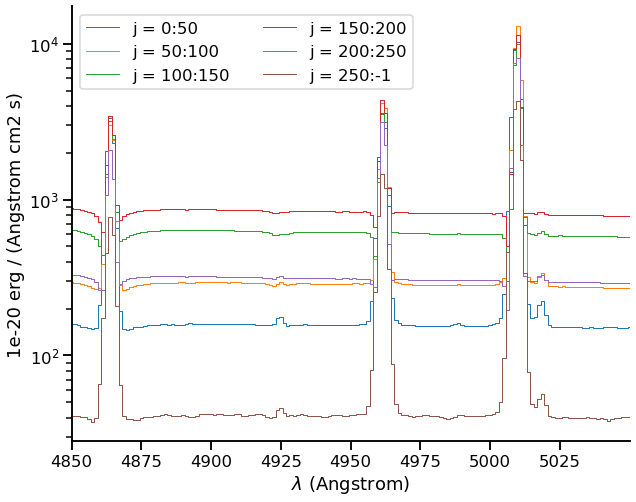

In [68]:
wide_band = cube.select_lambda(4850, 5050)
fig, ax = plt.subplots(figsize=(10, 8))
for (j1, j2) in jstrips:
    (wide_band[:, j1:j2, :]
     .mean(axis=(1, 2))
     .plot(label=f"j = {j1}:{j2}"))
ax.legend(ncol=2)
ax.set(yscale="log")
sns.despine();

So, this makes it look like all the lines are positive (but this is unfortunately not the case!).  The other weak lines that we see are He I 4922 and 5016 Å.

Set some limits for the continuum and line extraction:

In [70]:
wlim = {
    "4959": {
        "core": [4953.0, 4969.0],
        "blue": [4947.0, 4953.0],
        "red": [4969.0, 4975.0],
    },
    "5007": {
        "core": [5002.0, 5016.0],
        "blue": [4995.0, 5001.0],
        "red": [5022.0, 5028.0],
    }
}
rangecolors = {"core": "g", "blue": "b", "red": "r"}

Plot these limits zoomed in on the two [O III] lines:

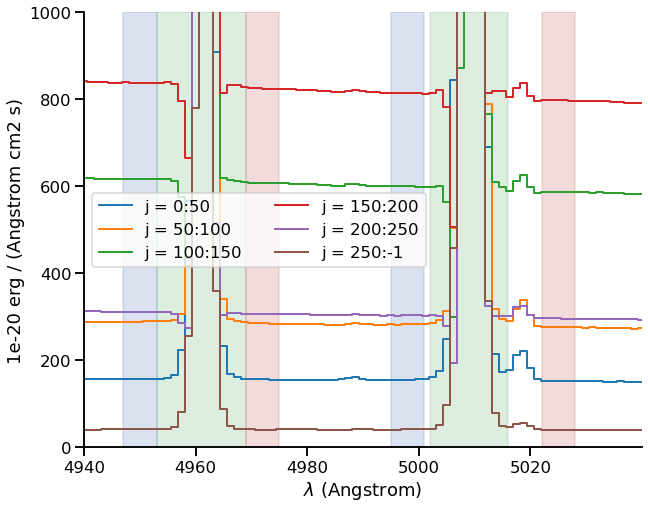

In [71]:
medium_band = cube.select_lambda(4940, 5040)
fig, ax = plt.subplots(figsize=(10, 8))
for (j1, j2) in jstrips:
    (medium_band[:, j1:j2, :]
     .mean(axis=(1, 2))
     .plot(label=f"j = {j1}:{j2}", linewidth=2))
    
for line, linedata in wlim.items():
    for span, spandata in linedata.items():
        ax.axvspan(
            spandata[0], spandata[1], 
            alpha=0.2, 
            color=rangecolors[span], 
            zorder=-100
        )
ax.legend(ncol=2)
ax.set(yscale="linear", ylim=[0.0, 1000])
sns.despine();

That seems to look fine.  Note that the red continuum band for 5007 is separated a bit from the core to allow space for the He I line (although it is so weak that this probably doesn't matter).

Now, we can use the same `wlim` data to extract the line and continuum:

In [75]:
def extract_core_and_cont(cube, spandata):
    """Return continuum-subtracted line core and continuum map
    
    The line core is a 3D cube over the narrow core wavelengths
    """
    cblue = cube.select_lambda(*spandata["blue"]).mean(axis=0)
    cred = cube.select_lambda(*spandata["red"]).mean(axis=0)
    cont = 0.5*(cblue + cred)
    core = cube.select_lambda(*spandata["core"]) - cont
    return core, cont

In [76]:
core5007, cont5007 = extract_core_and_cont(medium_band, wlim["5007"])
core4959, cont4959 = extract_core_and_cont(medium_band, wlim["4959"])

Plot the line core and the continuum for 5007 and 4959

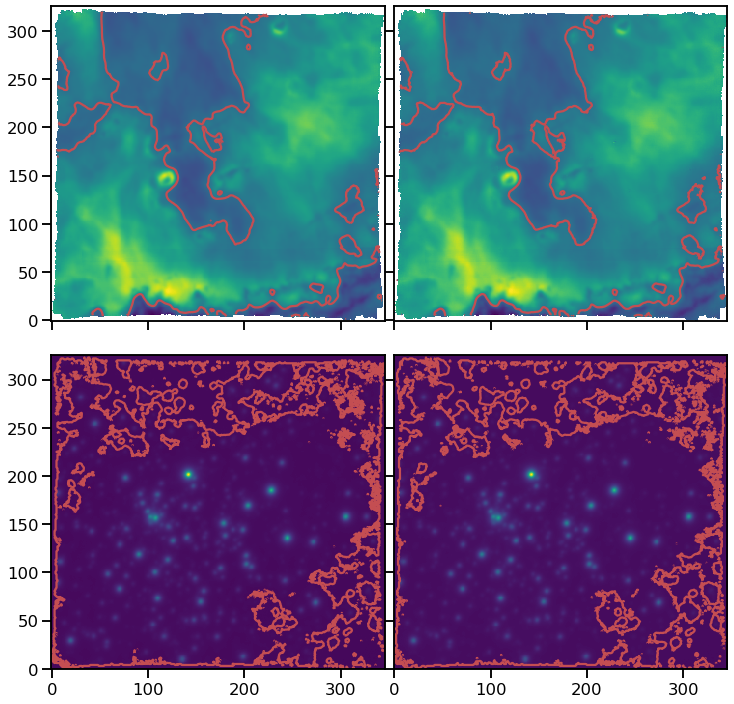

In [87]:
fig, axes = plt.subplots(
    2, 2,
    figsize=(10, 10), 
    sharex=True, 
    sharey=True,
)
core5007.sum(axis=0).plot(ax=axes[0, 0])
core4959.sum(axis=0).plot(ax=axes[0, 1])
cont5007.plot(ax=axes[1, 0], scale="sqrt")
cont4959.plot(ax=axes[1, 1], scale="sqrt")
axes[0, 0].contour(core5007.sum(axis=0).data, levels=[0.0], colors="r")
axes[0, 1].contour(core4959.sum(axis=0).data, levels=[0.0], colors="r")
axes[1, 0].contour(cont5007.data, levels=[0.0], colors="r")
axes[1, 1].contour(cont4959.data, levels=[0.0], colors="r")
fig.tight_layout(pad=0);

The red contours shoow the zero level.  Both lines pass through zero in exactly the same place.  The two continuum maps also have negative regions, but they are completely unrelated to in the line maps (although very similar between themsleves).

In [89]:
def find_moments(cube):
    """
    Returns the normalized wavelength moments: mom0, mom1, mom2
    
    mom0 is sum over wavelength
    mom1 is mean wavelength
    mom2 is rms wavelength width
    """
    wavcube = cube.clone(np.ones, np.zeros)
    wavcube.data *= cube.wave.coord()[:, None, None]
    wavcube.unit = u.angstrom
    mom0 = cube.sum(axis=0)
    mom1 = mom0.copy()
    mom1.data = np.sum(
        cube.data * wavcube.data, 
        axis=0
    ) / mom0
    mom2 = mom0.copy()
    mom2.data = np.sum(
        cube.data * (wavcube.data - mom1.data)**2, 
        axis=0
    ) / mom0
    mom2.data = np.sqrt(mom2.data)
    return mom0, mom1, mom2

<ipython-input-89-aaabe9cab2c1>:23: RuntimeWarning: invalid value encountered in sqrt
  mom2.data = np.sqrt(mom2.data)


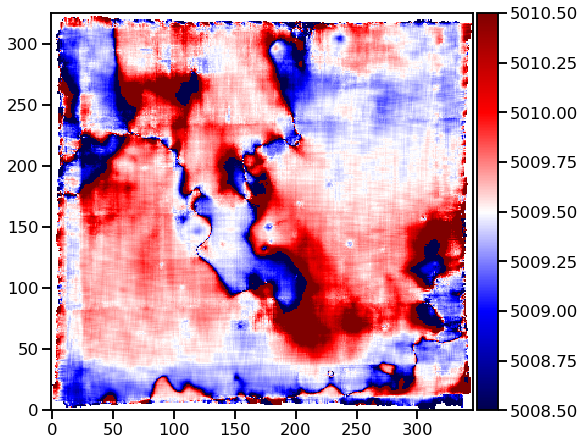

In [93]:
mom5007 = find_moments(core5007)
fig, ax = plt.subplots(figsize=(8, 8))
mom5007[1].plot(
    cmap="seismic",
    vmin=5008.5, 
    vmax=5010.5,
    colorbar="v",
);

This looks remarkably similar to the Ha moment map before correction

In [111]:
skyspec5007 = core5007[:, 8:9, 103:106].mean(axis=(1, 2))
skyspec4959 = core4959[:, 8:9, 103:106].mean(axis=(1, 2))

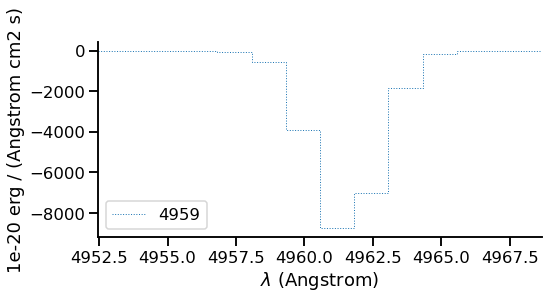

In [127]:
fig, ax = plt.subplots(figsize=(8,4))
skyspec4959.plot(ax=ax, label="4959", linestyle=":")
#skyspec5007.plot(ax=ax, label="5007", linestyle="--")
ax.legend()
fig.tight_layout()
sns.despine()

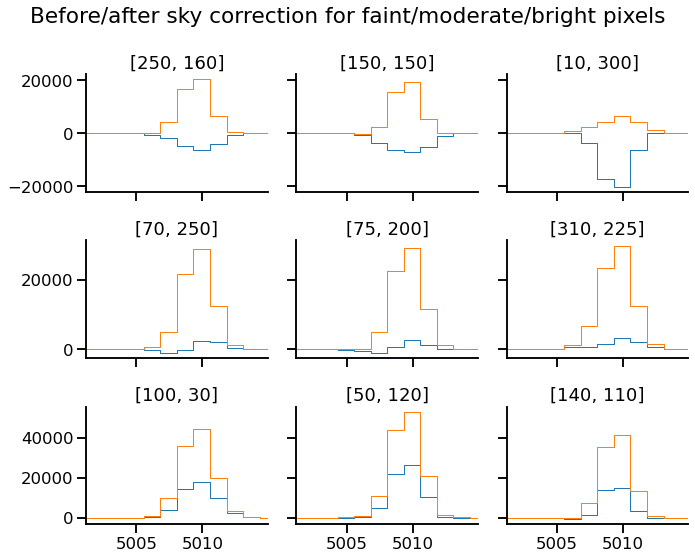

In [128]:
testpixels = [
    [250, 160], [150, 150], [10, 300],
    [70, 250], [75, 200], [310, 225],
    [100, 30], [50, 120], [140, 110], #[180, 290],
]
fig, axes = plt.subplots(
    3, 3, 
    figsize=(10, 8), 
    sharex=True,
    sharey="row",
)
for (j, i), ax in zip(testpixels, axes.flat):
    core5007[:, j, i].plot(ax=ax)
    (core5007[:, j, i] - skyspec5007).plot(ax=ax) 
    ax.set(xlabel="", ylabel="")
    ax.set_title(f"[{j}, {i}]")
fig.suptitle(
    "Before/after sky correction for faint/moderate/bright pixels"
)
sns.despine()
fig.tight_layout();

<ipython-input-89-aaabe9cab2c1>:23: RuntimeWarning: invalid value encountered in sqrt
  mom2.data = np.sqrt(mom2.data)
<ipython-input-89-aaabe9cab2c1>:23: RuntimeWarning: invalid value encountered in sqrt
  mom2.data = np.sqrt(mom2.data)


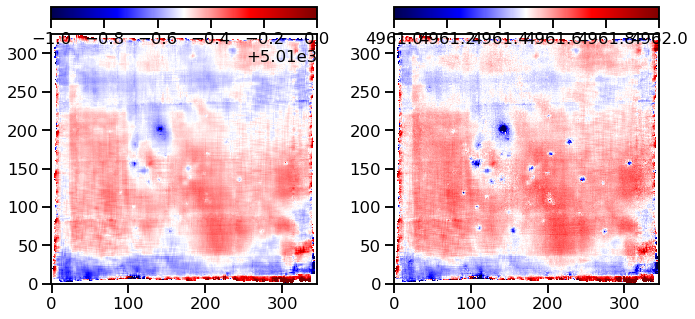

In [136]:
mom5007 = find_moments(core5007 - skyspec5007)
mom4959 = find_moments(core4959 - skyspec4959)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
mom5007[1].plot(
    cmap="seismic",
    vmin=5009.0, 
    vmax=5010.0,
    colorbar="h",
    ax=axes[0],
)
mom4959[1].plot(
    cmap="seismic",
    vmin=4961.0, 
    vmax=4962.0,
    colorbar="h",
    ax=axes[1],
)
fig.tight_layout(h_pad=10);

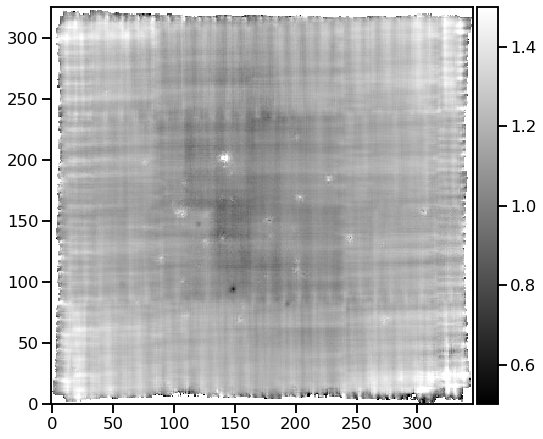

In [106]:
fig, ax = plt.subplots(figsize=(8, 8))
mom5007[2].plot(
    cmap="gray",
    vmin=0.5, 
    vmax=1.5,
    colorbar="v",
);

In [140]:
import pandas as pd

In [150]:
m = (mom5007[0].mask 
     | (mom5007[0].data < 2e4)
     | (mom5007[1].data < 5009.2) 
     | (mom5007[1].data > 5009.8)
     | (mom5007[2].data < 0.8)
     | (mom5007[2].data > 1.5)
    )
df = pd.DataFrame({
    "log10 I(5007)": np.log10(mom5007[0].data[~m]),
    "V(5007)": 3e5 * (mom5007[1].data[~m] - 5006.84) / 5006.84,
    "sig(5007)": 3e5 * mom5007[2].data[~m] / 5006.84,
})
df.describe()

,log10 I(5007),V(5007),sig(5007)
count,103785.000000,103785.000000,103785.000000
mean,4.923039,160.667440,70.423614
std,0.139926,3.951481,5.712461
min,4.305198,141.459858,48.015065
25%,4.824004,158.039236,66.792234
50%,4.928227,160.699411,70.376597
75%,5.026888,163.510750,73.752321
max,5.291500,177.349047,89.871209


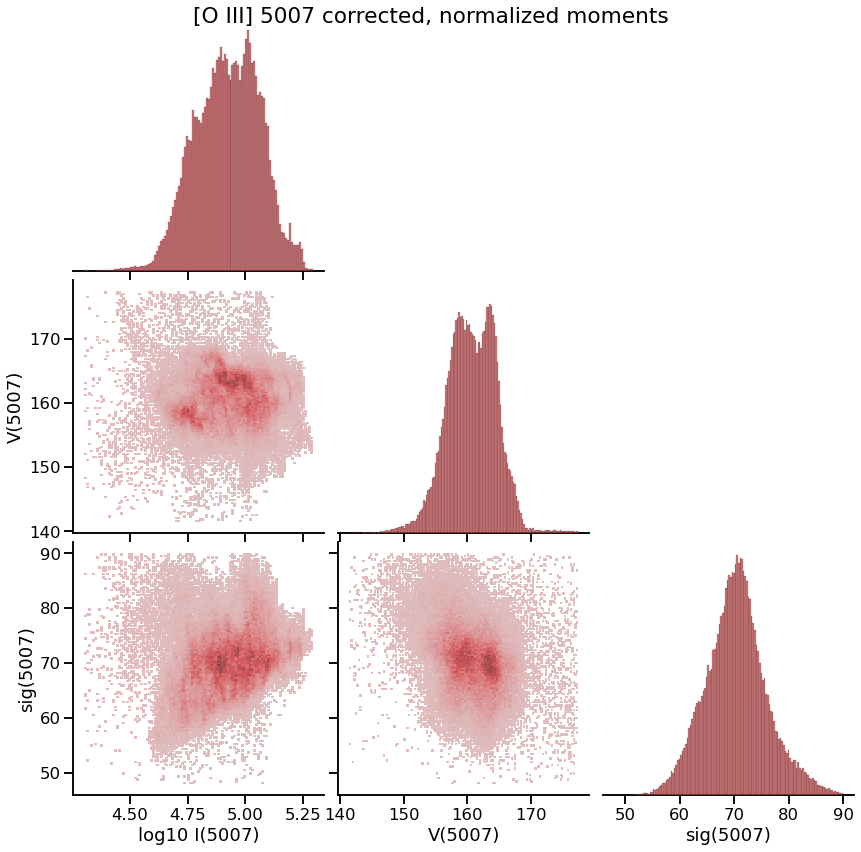

In [151]:
g = sns.pairplot(
    df,
    kind="hist",
    height=4,
    corner=True,
    plot_kws=dict(color="r"),
    diag_kws=dict(color="r"),
)
g.fig.suptitle("[O III] 5007 corrected, normalized moments")
g.tight_layout(pad=0);

In [155]:
m = (mom4959[0].mask 
     | (mom4959[0].data < 0.67e4)
     | (mom4959[1].data < 4961.2) 
     | (mom4959[1].data > 4961.8)
     | (mom4959[2].data < 0.8)
     | (mom4959[2].data > 1.5)
    )
df4959 = pd.DataFrame({
    "log10 I(4959)": np.log10(mom4959[0].data[~m]),
    "V(4959)": 3e5 * (mom4959[1].data[~m] - 4958.91) / 4958.91,
    "sig(4959)": 3e5 * mom4959[2].data[~m] / 4958.91,
})
df4959.describe()

,log10 I(4959),V(4959),sig(4959)
count,102735.000000,102735.000000,102735.000000
mean,4.449650,159.260461,74.547042
std,0.137717,4.002275,5.506318
min,3.826466,138.597412,48.587818
25%,4.351719,156.541333,70.979660
50%,4.454385,159.418835,74.349886
75%,4.551768,162.196549,77.866032
max,4.814876,174.831652,90.744251


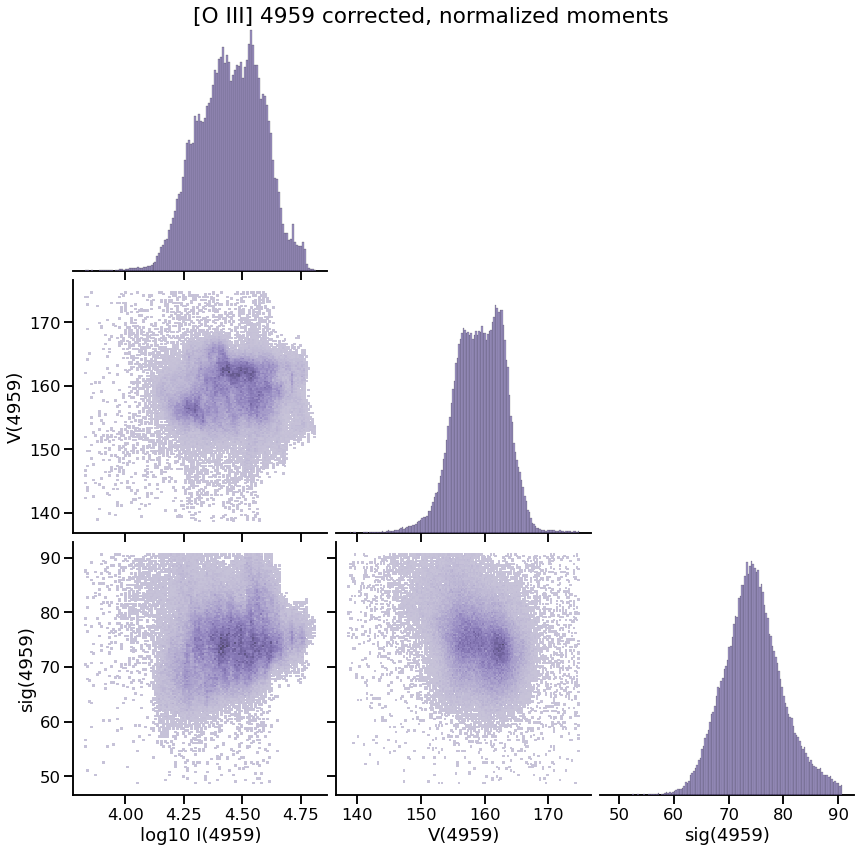

In [156]:
g = sns.pairplot(
    df4959,
    kind="hist",
    height=4,
    corner=True,
    plot_kws=dict(color="m"),
    diag_kws=dict(color="m"),
)
g.fig.suptitle("[O III] 4959 corrected, normalized moments")
g.tight_layout(pad=0);

The distributions are very consistent between the teo [O III] lines.  They are also quite similar to H alpha, especially in the mid-range of intensity.

There is clear evidence for a bimodal distribution of velocities, separated by about 10 km/s. A narrow component at 164 km/s and a broader component at 158 km/s. Then there is a third, weaker component at 166 km/s.  These are all from 5007 - the same is seen for 4959, but with a shift of -2 km/s.  Width is also higher for 4959 - could this be due to a blend with something?

There is a very slight reduction in line width with velocity, which is seen in all the lines.